# Kaggle - WiDS Datathon 2022

## Modelo Histórico - Lags + medias históricas

# 1. Modules

In [1767]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#model
from catboost import CatBoostRegressor

import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# 2. Data

In [1770]:
train_path = 'https://raw.githubusercontent.com/ccollado7/wds-datathon-2022/main/data/raw/train.csv'
test_path = 'https://raw.githubusercontent.com/ccollado7/wds-datathon-2022/main/data/raw/test.csv'
submit_path = 'https://raw.githubusercontent.com/ccollado7/wds-datathon-2022/main/data/raw/sample_solution.csv'

### Datos típicos:
+ Se usan solo para referencia
https://www.energystar.gov/sites/default/files/tools/Climate_and_Weather_2020_508.pdf

+ Referencias de Site_EUI y Source_EUI  (eui_normal.pdf)
https://www.energystar.gov/buildings/benchmark/understand_metrics/score_details

In [ ]:
ref_path= 'https://raw.githubusercontent.com/ccollado7/wds-datathon-2022/main/data/raw/eui_normal.csv'

In [1769]:
#train dataset
train = pd.read_csv(train_path)
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [1628]:
#test dataset
test = pd.read_csv(test_path)
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [1643]:
submit = pd.read_csv(submit_path)
submit.head()

,id,site_eui
0,75757,0.0
1,75758,0.0
2,75759,0.0
3,75760,0.0
4,75761,0.0


## Datos comparativos

In [1631]:
referencia = pd.read_csv(ref_path,sep='\t',header=None)
referencia.columns=['facility_type','site_eui_ref','source_eui_ref']
referencia.set_index('facility_type',inplace=True)

In [1632]:
resumen=train.groupby(['facility_type'])['site_eui','energy_star_rating'].mean()

In [1633]:
resumen2=test.groupby(['facility_type'])['energy_star_rating'].median()

In [1635]:
tabla=pd.merge(referencia,resumen,left_index=True, right_index=True)[['site_eui_ref','site_eui','energy_star_rating','source_eui_ref']]
tabla['ratio']=tabla.site_eui_ref/tabla.site_eui*100
tabla

,site_eui_ref,site_eui,energy_star_rating,source_eui_ref,ratio
facility_type,,,,,
Grocery_store_or_food_market,196.0,241.135162,51.762963,444.0,81.282215
Warehouse_Distribution_or_Shipping_center,22.7,39.559542,56.724551,52.9,57.381857
Retail_Enclosed_mall,65.7,100.965937,63.062500,170.7,65.071451
Education_Other_classroom,52.4,69.441531,61.258570,110.4,75.459165
Warehouse_Nonrefrigerated,22.7,38.209399,65.781910,52.9,59.409466
Warehouse_Selfstorage,20.2,21.589284,71.132075,47.8,93.564939
Data_Center,NaN,339.734876,36.555556,NaN,NaN
Commercial_Other,40.1,92.642037,65.343750,89.3,43.284886
Office_Medical_non_diagnostic,51.2,116.762294,49.167979,121.7,43.849772


In [1237]:
#pd.merge(referencia,resumen2,left_index=True, right_index=True)[['site_eui_ref','energy_star_rating']]

Según referencias son importantes cooling_degree_days y heating_degree_days, CDD y HDD

In [1641]:
print('CDD - median:',train.cooling_degree_days.median())
print('HDD - median:',train.heating_degree_days.median())

CDD - median: 1277.0
HDD - median: 4337.0


Los valores medios de USA son CDD: 1364 y HDD: 4233  https://www.energystar.gov/sites/default/files/tools/Multifamily_August_2018_EN_508.pdf

In [1438]:
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [1679]:
facility=data.facility_type.unique()
facility

array(['Grocery_store_or_food_market',
       'Warehouse_Distribution_or_Shipping_center',
       'Retail_Enclosed_mall', 'Education_Other_classroom',
       'Warehouse_Nonrefrigerated', 'Warehouse_Selfstorage',
       'Office_Uncategorized', 'Data_Center', 'Commercial_Other',
       'Mixed_Use_Predominantly_Commercial',
       'Office_Medical_non_diagnostic', 'Education_College_or_university',
       'Industrial', 'Laboratory',
       'Public_Assembly_Entertainment_culture',
       'Retail_Vehicle_dealership_showroom', 'Retail_Uncategorized',
       'Lodging_Hotel', 'Retail_Strip_shopping_mall',
       'Education_Uncategorized', 'Health_Care_Inpatient',
       'Public_Assembly_Drama_theater', 'Public_Assembly_Social_meeting',
       'Religious_worship', 'Mixed_Use_Commercial_and_Residential',
       'Office_Bank_or_other_financial', 'Parking_Garage',
       'Commercial_Unknown', 'Service_Vehicle_service_repair_shop',
       'Service_Drycleaning_or_Laundry', 'Public_Assembly_Recreation

Algunos outliers en temperaturas

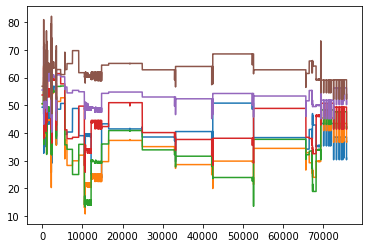

In [1707]:
plt.plot(train.december_avg_temp)
plt.plot(train.january_avg_temp)
plt.plot(train.february_avg_temp)
plt.plot(train.march_avg_temp)
plt.plot(train.april_avg_temp)
plt.plot(train.may_avg_temp)

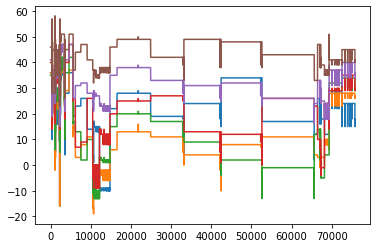

In [1708]:
plt.plot(train.december_min_temp)
plt.plot(train.january_min_temp)
plt.plot(train.february_min_temp)
plt.plot(train.march_min_temp)
plt.plot(train.april_min_temp)
plt.plot(train.may_min_temp)

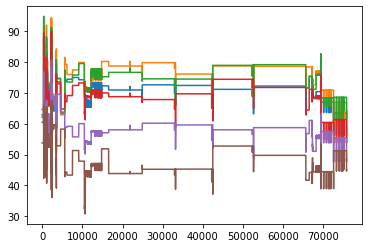

In [1709]:
plt.plot(train.june_avg_temp)
plt.plot(train.july_avg_temp)
plt.plot(train.august_avg_temp)
plt.plot(train.september_avg_temp)
plt.plot(train.october_avg_temp)
plt.plot(train.november_avg_temp)

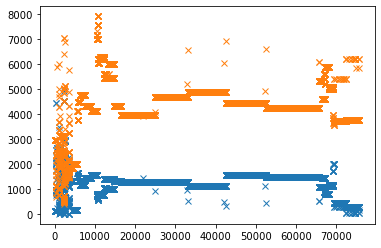

In [1715]:
plt.plot(train.cooling_degree_days,'x')
plt.plot(train.heating_degree_days,'x')

# 3. Feature Engineering

+ Reemplazo valores outliers por nulos
+ Armo categóricas para variables que quiero que sean tratadas así por catboost
+ Armo Lags

### Años de construcción en 0, si quiero corregir year_built=0 por nan

In [ ]:
#train[train['year_built'] == 0].year_built=np.nan
#test[test['year_built'] == 0].year_built=np.nan

In [ ]:
#train[train['building_class'] == 'Commercial'].ELEVATION=np.nan
#test[test['building_class'] == 'Commercial'].ELEVATION=np.nan

In [1680]:
#sns.lmplot( x='floor_area', y='ELEVATION', data=test, fit_reg=False, hue='building_class', legend=True)

In [1646]:
def list_duplicates(seq):
   seen = set()
   seen_add = seen.add
   # adds all elements it doesn't know yet to seen and all other to seen_twice
   seen_twice = set( x for x in seq if x in seen or seen_add(x) )
   # turn the set into a list (as requested)
   return list( seen_twice )

### Data = train + test

In [1647]:
test.index=test.index+len(train)
data=pd.concat([train,test],axis=0)

Corrijo valores de viento iguales a 1 y los reemplazo por nan

In [1648]:
feature_corrected='direction_peak_wind_speed'
data[feature_corrected]= data[feature_corrected].apply(lambda x: np.nan if x == 1 else x)
feature_corrected='max_wind_speed'
data[feature_corrected]= data[feature_corrected].apply(lambda x: np.nan if x == 1 else x)
feature_corrected='direction_max_wind_speed'
data[feature_corrected]= data[feature_corrected].apply(lambda x: np.nan if x == 1 else x)

### Armo categóricas de year_built y floor_area para catboost

In [1649]:
data.year_built=data.year_built.astype('Int64')
data.floor_area=np.ceil(data.floor_area).astype('Int64')

data.year_built=data.year_built.astype('str')
data.floor_area=data.floor_area.astype('str')

### Genero ID para armar lags

In [1651]:
#data['id2']= data[['floor_area','building_class','year_built','facility_type','State_Factor','ELEVATION']].apply(lambda x: '{}{}{}{}{}{}'.format(x[0],x[1],x[2],x[3],x[4],x[5]), axis=1)
data['id2']= data[['State_Factor','building_class','facility_type','year_built','floor_area']].apply(lambda x: '{}{}{}{}{}'.format(x[0],x[1],x[2],x[3],x[4]), axis=1)

In [1653]:
#data['idb']= data[['State_Factor','building_class','facility_type','year_built']].apply(lambda x: '{}{}{}{}'.format(x[0],x[1],x[2],x[3]), axis=1)

In [1652]:
data.groupby(['Year_Factor'])['id2'].describe()

,count,unique,top,freq
Year_Factor,,,,
1,2117,2111,State_6CommercialNursing_Home1972220000,2
2,9058,8878,State_6ResidentialMultifamily_Uncategorized193...,6
3,10879,10687,State_6ResidentialMultifamily_Uncategorized193...,6
4,12946,12746,State_6ResidentialMultifamily_Uncategorized193...,6
5,18308,18062,State_6ResidentialMultifamily_Uncategorized195...,6
6,22449,22127,State_4ResidentialMultifamily_Uncategorized195...,6
7,9705,9663,State_4ResidentialMultifamily_Uncategorized195...,6


In [1664]:
data[data.Year_Factor<7].id2.value_counts().sort_values(ascending=False)

State_1CommercialGrocery_store_or_food_market194261242    6
State_1CommercialOffice_Uncategorized1921246955           6
State_1CommercialOffice_Uncategorized192155785            6
State_1CommercialOffice_Uncategorized1922106052           6
State_1CommercialOffice_Uncategorized1921660631           6
                                                         ..
State_6ResidentialMultifamily_Uncategorized2006101452     1
State_6ResidentialMultifamily_Uncategorized1991146070     1
State_6CommercialOffice_Uncategorized1878181000           1
State_6ResidentialMultifamily_Uncategorized201368925      1
State_11Residential5plus_Unit_Building191040489           1
Name: id2, Length: 26760, dtype: int64

In [1665]:
data[data.Year_Factor==7].id2.value_counts().sort_values(ascending=False)

State_4ResidentialMultifamily_Uncategorized1950593107     6
State_4ResidentialMultifamily_Uncategorized19521075007    5
State_4ResidentialMultifamily_Uncategorized19602892677    5
State_4ResidentialMultifamily_Uncategorized1995540967     4
State_4ResidentialMultifamily_Uncategorized1964671337     4
                                                         ..
State_11Residential5plus_Unit_Building200225514           1
State_11Residential5plus_Unit_Building2008197368          1
State_11Residential5plus_Unit_Building199633456           1
State_11Residential5plus_Unit_Building198987645           1
State_11Residential5plus_Unit_Building199445640           1
Name: id2, Length: 9663, dtype: int64

In [1666]:
data.id2.value_counts().sort_values(ascending=False)

State_1CommercialGrocery_store_or_food_market194261242      7
State_1CommercialOffice_Uncategorized1905174765             7
State_1CommercialOffice_Uncategorized1979239133             7
State_1CommercialLodging_Hotel191254882                     7
State_1CommercialRetail_Uncategorized2006337000             7
                                                           ..
State_6CommercialEducation_Preschool_or_daycare192214790    1
State_6CommercialEducation_Other_classroom1931138004        1
State_6CommercialEducation_Other_classroom2001141261        1
State_6CommercialEducation_Other_classroom2012150744        1
State_11Residential5plus_Unit_Building2016185611            1
Name: id2, Length: 27424, dtype: int64

### Elijo las columnas a ser usadas en los lags, los lags incluyen del 1 al 6 (si existen y sino se reempalzan por nan)

In [1667]:
def make_lag(data,feature,i):
    data[feature+'_lag'+str(i)] = (data.groupby('id2',as_index=False)
                          .apply(lambda x: x[feature].shift(1))
                          .reset_index(level=0, drop=True))
    return data

In [1658]:
#columnas=['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'january_max_temp','february_min_temp', 'february_avg_temp', 'february_max_temp','march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
#'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp','may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
#'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp','august_avg_temp', 'august_max_temp', 'september_min_temp',
#'september_avg_temp', 'september_max_temp', 'october_min_temp','october_avg_temp', 'october_max_temp', 'november_min_temp',
#'november_avg_temp', 'november_max_temp', 'december_min_temp','december_avg_temp', 'december_max_temp', 'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
#'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F','days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
#'days_above_100F', 'days_above_110F', 'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

columnas=['energy_star_rating','heating_degree_days','cooling_degree_days', 'site_eui']

for i in range(1,7):
    for columna in columnas:
        data[columna+'_lag'+str(i)]=np.nan

### Función que arma lags (se toma su tiempo)

In [1659]:
for i in range(7,0,-1):
    print('----------------------------------------------------')   
    print('Year_Factor_'+str(i))   
    df=data[(data['Year_Factor']==i)]
    t=df['id2']
    b=df['id2'].unique()
    print('ids distintos en el año: ',len(b))
    id_duplicados=list_duplicates(t)
    res=[]
    print('cantidad duplicados:',len(id_duplicados))
    [res.append(x) for x in b if x not in id_duplicados]
    print('ids unicos:',len(res))
    rowIndex = data[(data['id2'].isin(id_duplicados))&(data.Year_Factor==i)].index
    data.loc[rowIndex,['id2']]=data.loc[rowIndex,['id2']]+str(i)
    
    resIndex = data[(data['id2'].isin(res))&(data.Year_Factor==i)].index
        
    for j in range(7,0,-1):
        if (i>j):
            dfx=data[(data['Year_Factor']==j)]
            a=(dfx.id2.unique())
            comunes=(set(a) & set(res))
            print('año->',i,'con previo->',j,'ids comunes ->',len(comunes),'lag->',i-j)
            cIndex = data.loc[(data[data.id2.isin(comunes)].index)&(data[(data.Year_Factor==i) | (data.Year_Factor==j)].index)].index
            for columna in columnas:
                data.loc[cIndex]=make_lag(data.loc[cIndex],columna,i-j)

----------------------------------------------------
Year_Factor_7
ids distintos en el año:  9663
cantidad duplicados: 27
ids unicos: 9636
año-> 7 con previo-> 6 ids comunes -> 8495 lag-> 1
año-> 7 con previo-> 5 ids comunes -> 7202 lag-> 2
año-> 7 con previo-> 4 ids comunes -> 2767 lag-> 3
año-> 7 con previo-> 3 ids comunes -> 1657 lag-> 4
año-> 7 con previo-> 2 ids comunes -> 501 lag-> 5
año-> 7 con previo-> 1 ids comunes -> 312 lag-> 6
----------------------------------------------------
Year_Factor_6
ids distintos en el año:  22127
cantidad duplicados: 250
ids unicos: 21877
año-> 6 con previo-> 5 ids comunes -> 15934 lag-> 1
año-> 6 con previo-> 4 ids comunes -> 10379 lag-> 2
año-> 6 con previo-> 3 ids comunes -> 8590 lag-> 3
año-> 6 con previo-> 2 ids comunes -> 7399 lag-> 4
año-> 6 con previo-> 1 ids comunes -> 1747 lag-> 5
----------------------------------------------------
Year_Factor_5
ids distintos en el año:  18062
cantidad duplicados: 190
ids unicos: 17872
año-> 5 con prev

In [1710]:
#rowIndex=data[data.Year_Factor==7].energy_star_rating.notnull().index

In [1716]:
#rowIndex=data[data.energy_star_rating_lag1.notnull()].index
#data.loc[rowIndex][['Year_Factor','energy_star_rating','site_eui','ELEVATION','cooling_degree_days','heating_degree_days']]

In [1717]:
data.isnull().sum()

Year_Factor                     0
State_Factor                    0
building_class                  0
facility_type                   0
floor_area                      0
                            ...  
site_eui_lag6               85150
energy_star_rating_last     49719
heating_degree_days_last    28368
cooling_degree_days_last    28368
site_eui_last               28368
Length: 93, dtype: int64

In [1694]:
data.columns # se inluyen lags

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

### Implemento "last" como la media de los lags disponibles de las columnas elegidas 

In [1744]:
columnas_last=[]
for columna in columnas:
    data[columna+'_last']=data[[columna+'_lag1',columna+'_lag2',columna+'_lag3',columna+'_lag4',columna+'_lag5',columna+'_lag6']].mean(axis=1)
    columnas_last.append(columna+'_last')

In [1735]:
columnas_last

['energy_star_rating_last',
 'heating_degree_days_last',
 'cooling_degree_days_last',
 'site_eui_last']

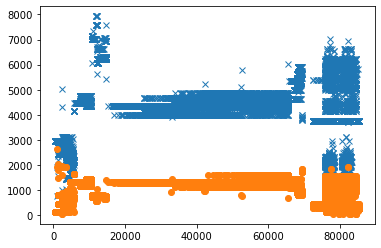

In [1745]:
plt.plot(data.heating_degree_days_last,'x')
plt.plot(data.cooling_degree_days_last,'o')

## Armados los lags e _hist separo el dataset de train y test (train_ampliado y test_ampliado)

In [1698]:
train_ampliado=data[data.Year_Factor<7]
test_ampliado=data[data.Year_Factor==7]
test_ampliado.index=test_ampliado.index-len(train_ampliado)

# 4. Modelos

### Selecciono features

In [1746]:
features_selected=list(train.columns)+columnas_last #no uso lags sino last

In [1702]:
X_train=train_ampliado[features_selected]
X_train = X_train.drop(['site_eui','id'],axis=1)
cat_features = list(X_train.select_dtypes(include=['object']).columns)
print(cat_features)
y = train_ampliado.site_eui
y

X_test=test_ampliado
X_test=X_test[features_selected]
X_test = X_test.drop(['id','site_eui'], axis=1)

['State_Factor', 'building_class', 'facility_type', 'floor_area', 'year_built']


### Modelo 1 - Sin CV, default params -> Kaggle score: 25.705

In [1703]:
model_1 = CatBoostRegressor(cat_features = cat_features,verbose = 100, max_ctr_complexity = 6) #
model_1.fit(X_train,y)

Learning rate set to 0.08112
0:	learn: 56.2693864	total: 112ms	remaining: 1m 52s
100:	learn: 34.5364299	total: 11s	remaining: 1m 37s
200:	learn: 33.3791988	total: 21.7s	remaining: 1m 26s
300:	learn: 32.6948804	total: 32.7s	remaining: 1m 15s
400:	learn: 31.7509656	total: 45.2s	remaining: 1m 7s
500:	learn: 31.0287485	total: 56.3s	remaining: 56.1s
600:	learn: 30.5436560	total: 1m 7s	remaining: 44.7s
700:	learn: 29.8360755	total: 1m 18s	remaining: 33.5s
800:	learn: 29.1824546	total: 1m 29s	remaining: 22.4s
900:	learn: 28.7670453	total: 1m 41s	remaining: 11.1s
999:	learn: 28.3051166	total: 1m 52s	remaining: 0us


In [1704]:
y_predict=model_1.predict(X_test)
y_predict[y_predict<0]=1
submit['site_eui'] = y_predict
submit.to_csv('model_1_last.csv',index=False)

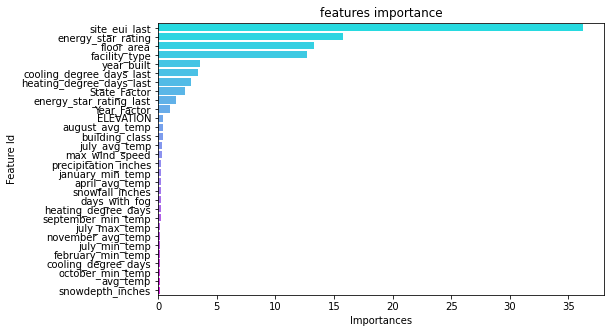

In [1705]:
df_feature_importance = pd.DataFrame(model_1.get_feature_importance(prettified=True))
plt.figure(figsize=(8, 5));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance[:30],palette="cool");
plt.title('features importance');

In [1706]:
#le = LabelEncoder()

#for i in X_train.columns:
#    if X_train[i].dtypes == 'object':
#        X_train[i] = le.fit_transform(X_train[i])
#        print(i)

#for i in X_test.columns:
#    if X_test[i].dtypes == 'object':
#        X_test[i] = le.fit_transform(X_test[i])
#        print(i)

### Modelo 2 - CV para manejar lags e históricos -> Kaggle Score: 29.448
+  entreno en años < year y valido en year

In [1718]:
def get_model():
    cat_params = {
        'iterations': 10000,
        'learning_rate': 0.025,
        'od_wait': 1000,
        'depth': 8,
        #'task_type' : 'GPU',
        #'devices' : '0',
        'verbose' : 1000,
        "objective": "RMSE",
        "loss_function": "RMSE",
        "cat_features" : cat_features
    }
    model =  CatBoostRegressor(**cat_params)
    return model

In [1507]:
from sklearn import model_selection
kfold = model_selection.KFold(7, shuffle=True, random_state=2022)
models = []
train_with_k_fold = False
apply_psudo_labeling = False


for year in range(2,6):
    train_indices=X_train[X_train.Year_Factor<=year].index
    val_indices=X_train[X_train.Year_Factor==year+1].index
    X_train_cv = X_train.iloc[train_indices]
    y_train_cv = y.iloc[train_indices]
    X_val_cv = X_train.iloc[val_indices]
    y_val_cv = y.iloc[val_indices]
    model = get_model()
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv))
    models.append(model)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 59.7086723	test: 60.6967096	best: 60.6967096 (0)	total: 97.9ms	remaining: 16m 18s
1000:	learn: 39.9444519	test: 49.0981931	best: 48.8446599 (472)	total: 1m 14s	remaining: 11m 6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 48.84465992
bestIteration = 472

Shrink model to first 473 iterations.
0:	learn: 60.0938794	test: 57.8324923	best: 57.8324923 (0)	total: 94.4ms	remaining: 15m 43s
1000:	learn: 40.9823393	test: 35.3952866	best: 35.3300064 (788)	total: 1m 14s	remaining: 11m 5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 35.33000636
bestIteration = 788

Shrink model to first 789 iterations.
0:	learn: 59.2059068	test: 56.1820757	best: 56.1820757 (0)	total: 97.3ms	remaining: 16m 12s
1000:	learn: 33.7356764	test: 45.7942429	best: 40.4005992 (143)	total: 1m 25s	remaining: 12m 52s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 40.40059923
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 58.10010

In [1510]:
y_predict=np.median([model.predict(X_test) for model in models], axis=0)
y_predict

array([159.15295933, 261.04718239, 192.56008579, ...,  41.68954474,
        49.42213736,  43.78576288])

In [1511]:
submit['site_eui'] = y_predict
submit.to_csv('modelo_cv_last.csv',index=False)
submit.head()

,id,site_eui
0,75757,159.152959
1,75758,261.047182
2,75759,192.560086
3,75760,255.809353
4,75761,235.086598


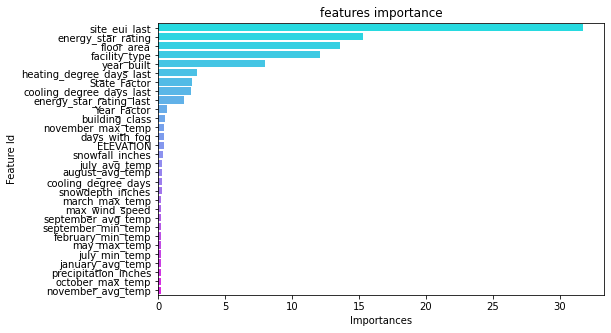

In [1516]:
df_feature_importance = pd.DataFrame(models[0].get_feature_importance(prettified=True))
plt.figure(figsize=(8, 5));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance[:30],palette="cool");
plt.title('features importance');

### Modelo 3 - CV clásico shuffle (puede tener problemas con lags e históricos) -> Kaggle Score: 23.114

In [1512]:
from sklearn import model_selection
kfold = model_selection.KFold(5, shuffle=True, random_state=2022)
models = []
train_with_k_fold = False
apply_psudo_labeling = False


for train_indices, val_indices in kfold.split(X_train):
    X_train_cv = X_train.iloc[train_indices]
    y_train_cv = y.iloc[train_indices]
    X_val_cv = X_train.iloc[val_indices]
    y_val_cv = y.iloc[val_indices]
    model = get_model()
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv))
    models.append(model)

0:	learn: 57.7782407	test: 56.8570586	best: 56.8570586 (0)	total: 140ms	remaining: 23m 15s
1000:	learn: 29.8564157	test: 30.7740736	best: 30.7740736 (1000)	total: 2m 16s	remaining: 20m 31s
2000:	learn: 25.5496536	test: 30.0764788	best: 30.0660850 (1964)	total: 4m 41s	remaining: 18m 44s
3000:	learn: 23.6125806	test: 29.8997177	best: 29.8982264 (2984)	total: 7m 4s	remaining: 16m 29s
4000:	learn: 21.9733037	test: 30.0842937	best: 29.8957983 (3203)	total: 9m 30s	remaining: 14m 15s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 29.89579827
bestIteration = 3203

Shrink model to first 3204 iterations.
0:	learn: 57.1108169	test: 59.5414792	best: 59.5414792 (0)	total: 136ms	remaining: 22m 43s
1000:	learn: 28.9419195	test: 32.5735622	best: 32.5600639 (995)	total: 2m 20s	remaining: 21m 6s
2000:	learn: 25.6131450	test: 31.7197307	best: 31.7024164 (1918)	total: 4m 45s	remaining: 19m 1s
3000:	learn: 23.6059359	test: 31.4920284	best: 31.4903622 (2874)	total: 7m 14s	remaining: 16m

In [1513]:
y_predict=np.mean([model.predict(X_test) for model in models], axis=0)

In [1514]:
submit['site_eui'] = y_predict
submit.to_csv('modelo_cv_overfitting.csv',index=False)
submit.head()
#38.465

,id,site_eui
0,75757,139.360912
1,75758,256.794872
2,75759,155.922809
3,75760,256.087742
4,75761,246.074995


## Modelo 4 - CV-modificado -> Kaggle Score: 22.249

+ Se hacen 3 CV sólo del año 6 (para que sea un 10% de train)
+ Solo se valida con datos del año 6
+ Los 3 usan los mismos datos del año 1 al 5 

In [1721]:
X_train=train_ampliado[features_selected]

X_train6=X_train[X_train.Year_Factor==6]

X_train1_5=X_train[X_train.Year_Factor<6]

X_train = X_train.drop(['site_eui','id'],axis=1)
cat_features= list(X_train.select_dtypes(include=['object']).columns)
print(cat_features)
y = train_ampliado.site_eui
y
y6=X_train6.site_eui
y1_5=X_train1_5.site_eui
X_train6 = X_train6.drop(['site_eui','id'],axis=1)
#X_train6 = X_train6.drop(['site_eui','id','id2'],axis=1)
X_train1_5 = X_train1_5.drop(['site_eui','id'],axis=1)
#X_train1_5 = X_train1_5.drop(['site_eui','id','id2'],axis=1)

['State_Factor', 'building_class', 'facility_type', 'floor_area', 'year_built']


In [1722]:
def get_model():
    cat_params = {
        'iterations': 10000,
        'learning_rate': 0.025,
        'od_wait': 1000,
        'depth': 8,
        #'task_type' : 'GPU',
        #'devices' : '0',
        'verbose' : 1000,
        "objective": "RMSE",
        "loss_function": "RMSE",
        "cat_features" : cat_features
    }
    model =  CatBoostRegressor(**cat_params)
    return model

In [1723]:
from sklearn import model_selection
kfold = model_selection.KFold(3, shuffle=True, random_state=2022)
models = []

base_indice=train_indices1_5[-1]
for train_indices, val_indices in kfold.split(X_train6):
    X_train_cv6 = X_train6.iloc[train_indices]
    X_train_cv=pd.concat([X_train1_5,X_train_cv6])
    #print(len(X_train_cv))
    #print('len_indices',len(train_indices))
    #print('val',len(val_indices))
    y_train_cv = pd.concat([y1_5,y6.iloc[train_indices]])
    X_val_cv = X_train6.iloc[val_indices]
    y_val_cv = y6.iloc[val_indices]
    model = get_model()
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv))
    models.append(model)

0:	learn: 57.9814504	test: 53.9152607	best: 53.9152607 (0)	total: 160ms	remaining: 26m 43s
1000:	learn: 28.4478251	test: 26.5418045	best: 26.5418045 (1000)	total: 2m 28s	remaining: 22m 11s
2000:	learn: 24.9731428	test: 26.4586627	best: 26.4382396 (1890)	total: 5m 1s	remaining: 20m 6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 26.43823961
bestIteration = 1890

Shrink model to first 1891 iterations.
0:	learn: 57.7476390	test: 56.2114801	best: 56.2114801 (0)	total: 152ms	remaining: 25m 20s
1000:	learn: 29.5729550	test: 33.1129575	best: 33.1124801 (999)	total: 2m 28s	remaining: 22m 14s
2000:	learn: 24.9908243	test: 32.9464760	best: 32.8870649 (1690)	total: 5m	remaining: 20m
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 32.88706489
bestIteration = 1690

Shrink model to first 1691 iterations.
0:	learn: 57.4411903	test: 58.7299620	best: 58.7299620 (0)	total: 154ms	remaining: 25m 41s
1000:	learn: 29.5372162	test: 30.7793665	best: 30.7733320 (987)	

In [1724]:
X_test=test_ampliado
X_test=X_test[features_selected]
X_test = X_test.drop(['id','site_eui'], axis=1)

y_predict=np.mean([model.predict(X_test) for model in models], axis=0)
y_predict[y_predict<0]=1

In [1725]:
submit['site_eui'] = y_predict
submit.to_csv('modelo_cv_3.csv',index=False)
submit.head()
#38.465

,id,site_eui
0,75757,138.277435
1,75758,260.464295
2,75759,178.244288
3,75760,259.646200
4,75761,245.132939


## Modelo 4.b -> Kaggle Score: 22.173

+ igual al 4 pero median en lugar de mean para votación de los modelos

In [1726]:
X_test=test_ampliado
X_test=X_test[features_selected]
X_test = X_test.drop(['id','site_eui'], axis=1)

y_predictm=np.median([model.predict(X_test) for model in models], axis=0)
y_predictm[y_predictm<0]=1

In [1733]:
submit['site_eui'] = y_predictm
submit.to_csv('modelo_cv_3_median.csv',index=False)
submit.head()

,id,site_eui
0,75757,137.867627
1,75758,260.585103
2,75759,177.595701
3,75760,256.076809
4,75761,242.435149


array([[1.        , 0.99891981],
       [0.99891981, 1.        ]])

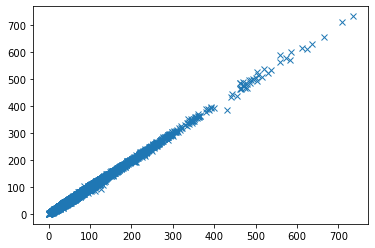

In [1732]:
plt.plot(y_predict,y_predictm,'x')
np.corrcoef(y_predict,y_predictm)

## Modelo 5 - saco otras features del dataset  -> Kaggle score: 22.569
+ saco temperaturas con detalle mensual
+ no mejoro respecto de dejarlas

In [1753]:
features_selected=list(train.columns)+columnas_last #no uso lags sino last
unwanted={'january_min_temp',
 'january_avg_temp',
 'january_max_temp',
 'february_min_temp',
 'february_avg_temp',
 'february_max_temp',
 'march_min_temp',
 'march_avg_temp',
 'march_max_temp',
 'april_min_temp',
 'april_avg_temp',
 'april_max_temp',
 'may_min_temp',
 'may_avg_temp',
 'may_max_temp',
 'june_min_temp',
 'june_avg_temp',
 'june_max_temp',
 'july_min_temp',
 'july_avg_temp',
 'july_max_temp',
 'august_min_temp',
 'august_avg_temp',
 'august_max_temp',
 'september_min_temp',
 'september_avg_temp',
 'september_max_temp',
 'october_min_temp',
 'october_avg_temp',
 'october_max_temp',
 'november_min_temp',
 'november_avg_temp',
 'november_max_temp',
 'december_min_temp',
 'december_avg_temp',
 'december_max_temp'}

features_selected= [ele for ele in features_selected if ele not in unwanted]

In [1755]:
X_train=train_ampliado[features_selected]

X_train6=X_train[X_train.Year_Factor==6]

X_train1_5=X_train[X_train.Year_Factor<6]

X_train = X_train.drop(['site_eui','id'],axis=1)
cat_features= list(X_train.select_dtypes(include=['object']).columns)
print(cat_features)
y = train_ampliado.site_eui
y
y6=X_train6.site_eui
y1_5=X_train1_5.site_eui
X_train6 = X_train6.drop(['site_eui','id'],axis=1)
X_train1_5 = X_train1_5.drop(['site_eui','id'],axis=1)

['State_Factor', 'building_class', 'facility_type', 'floor_area', 'year_built']


In [1756]:
from sklearn import model_selection
kfold = model_selection.KFold(3, shuffle=True, random_state=2022)
models = []

base_indice=train_indices1_5[-1]
for train_indices, val_indices in kfold.split(X_train6):
    X_train_cv6 = X_train6.iloc[train_indices]
    X_train_cv=pd.concat([X_train1_5,X_train_cv6])
    y_train_cv = pd.concat([y1_5,y6.iloc[train_indices]])
    X_val_cv = X_train6.iloc[val_indices]
    y_val_cv = y6.iloc[val_indices]
    model = get_model()
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv))
    models.append(model)

0:	learn: 58.0036200	test: 53.9357358	best: 53.9357358 (0)	total: 155ms	remaining: 25m 45s
1000:	learn: 27.4899874	test: 26.7575041	best: 26.7356134 (807)	total: 2m 22s	remaining: 21m 16s
2000:	learn: 24.9700250	test: 26.8970130	best: 26.7331276 (1312)	total: 4m 48s	remaining: 19m 15s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 26.73312763
bestIteration = 1312

Shrink model to first 1313 iterations.
0:	learn: 57.7702159	test: 56.2320102	best: 56.2320102 (0)	total: 165ms	remaining: 27m 29s
1000:	learn: 28.6984682	test: 33.3213316	best: 33.3213316 (1000)	total: 2m 16s	remaining: 20m 31s
2000:	learn: 24.8995784	test: 33.1481331	best: 33.1404739 (1571)	total: 4m 44s	remaining: 18m 58s
3000:	learn: 22.8688636	test: 32.9910244	best: 32.9885471 (2984)	total: 7m 16s	remaining: 16m 57s
4000:	learn: 21.3006940	test: 33.0104615	best: 32.9602937 (3228)	total: 9m 55s	remaining: 14m 53s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 32.96029366
bestIterat

In [1757]:
X_test=test_ampliado
X_test=X_test[features_selected]
X_test = X_test.drop(['id','site_eui'], axis=1)

y_predict=np.median([model.predict(X_test) for model in models], axis=0)
y_predict[y_predict<0]=1

In [1759]:
submit['site_eui'] = y_predict
submit.to_csv('modelo_cv_3_sintemp_median.csv',index=False)
submit.head()

,id,site_eui
0,75757,132.480268
1,75758,259.314854
2,75759,172.814112
3,75760,259.027619
4,75761,246.869039
